In [2]:
library(monocle3)
library(Seurat)
library(dplyr)
library(biomaRt)
library(stringr)
library(SCORPIUS)
library(ggplot2)

In [2]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

In [4]:
f = paste(out, "obj.integrated.frazer.melton", sep = "")
load(f, verbose = T)

Loading objects:
  integrated


In [5]:
integrated

An object of class Seurat 
60358 features across 112509 samples within 2 assays 
Active assay: RNA (58358 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [6]:
data = integrated

In [7]:
integrated = NULL

In [8]:
expression_matrix = data@assays$RNA

In [9]:
cell_metadata = data@meta.data
cell_metadata = cell_metadata[rownames(cell_metadata) %in% colnames(expression_matrix),]
cell_metadata$cell <- rownames(cell_metadata)
gene_annotation = data.frame(row.names = rownames(expression_matrix), id = rownames(expression_matrix), gene_short_name = rownames(expression_matrix))

In [10]:
cds <- new_cell_data_set(expression_matrix[, rownames(cell_metadata)],
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)

In [11]:
cds@reducedDims$PCA = Embeddings(object = data[["pca"]])
cds@reducedDims$UMAP = Embeddings(object = data[["umap"]])
cds = cluster_cells(cds, reduction_method='UMAP')

In [12]:
## When you learn_graph(cds, use_partition=F) you cannot set root node to a partition > 1 (per https://github.com/cole-trapnell-lab/monocle-release/issues/280)
## set all partitions to 1 for workaround.
levels(cds@clusters$UMAP$partitions)

[1] "1" "2" "3" "4" "5" "6"

In [13]:
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '2'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '3'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '4'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '5'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '6'] <- '1'

In [14]:
cds = learn_graph(cds, use_partition=F)

  |======================================================================| 100%


In [15]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, cell_phenotype, root_type){

    cell_ids <- which(pData(cds)[, cell_phenotype] == root_type)


    closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
    closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
    root_pr_nodes <- igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))]

    root_pr_nodes
}


In [19]:
save(cds, file = paste(out, "obj.integrated.frazer.melton_pseudotime", sep = ""))

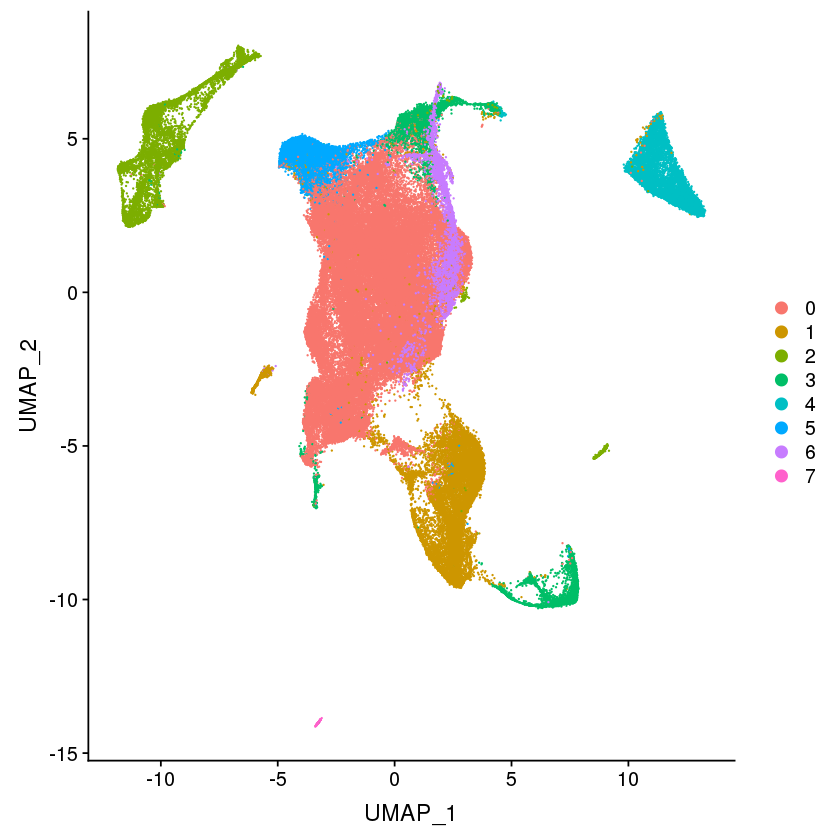

In [28]:
DimPlot(data, group.by = "integrated_snn_res.0.075")

In [27]:
get_earliest_principal_node(cds, "integrated_snn_res.0.075", "4")

[1] "Y_235"

In [29]:
cds = order_cells(cds, root_pr_nodes = 'Y_235')

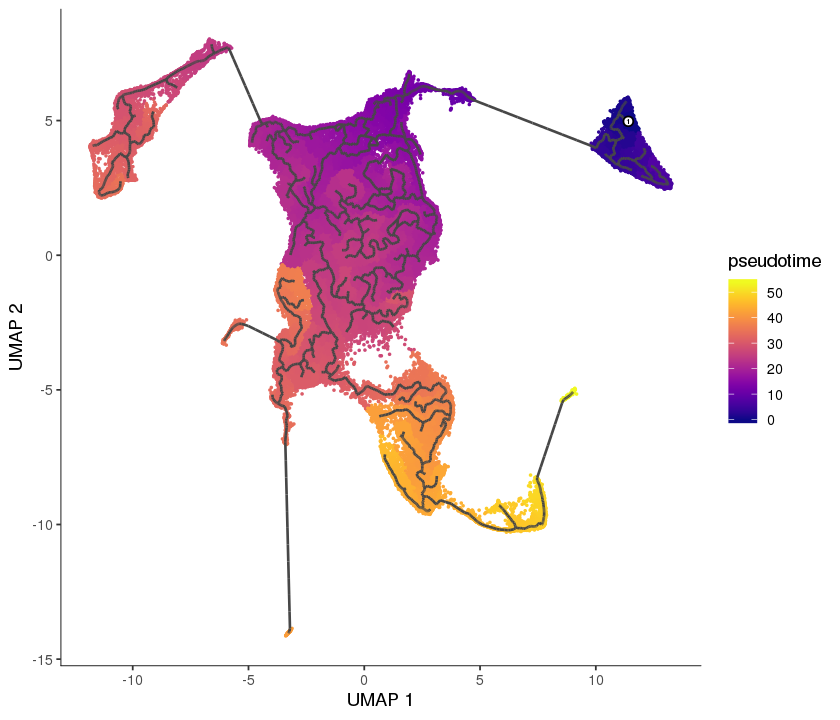

In [30]:
options(repr.plot.width =7, repr.plot.height = 6)
plot_cells(cds, 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

In [31]:
genes = c("PDX1", "NKX6-1", "CHGA")

lineage_cds = cds[rowData(cds)$gene_short_name %in% genes,]

In [37]:
save(lineage_cds, file = paste(out, "obj.integrated.frazer.melton_pseudotime.lineage", sep = ""))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

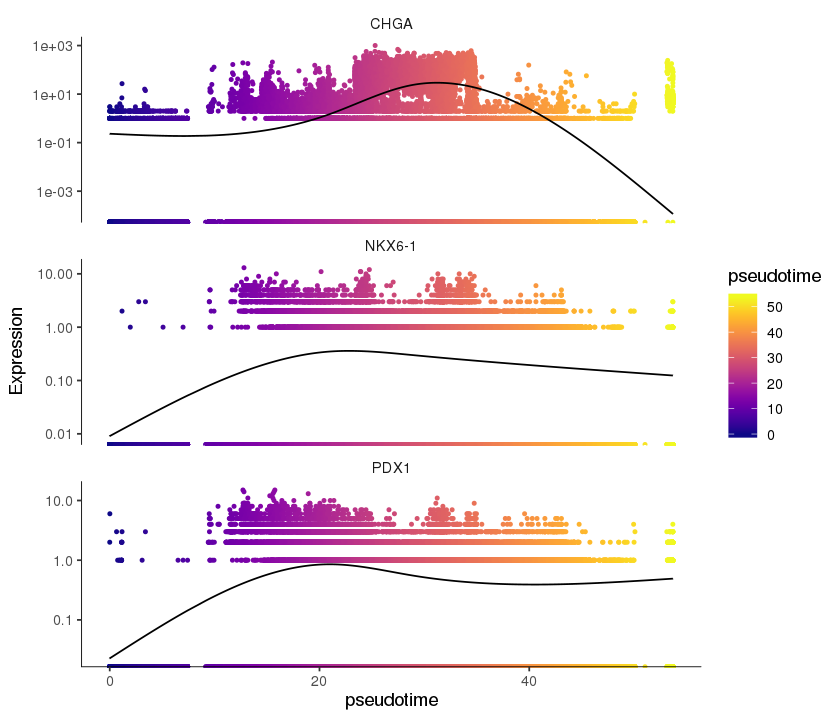

In [32]:
plot_genes_in_pseudotime(lineage_cds, 
                         color_cells_by="pseudotime")

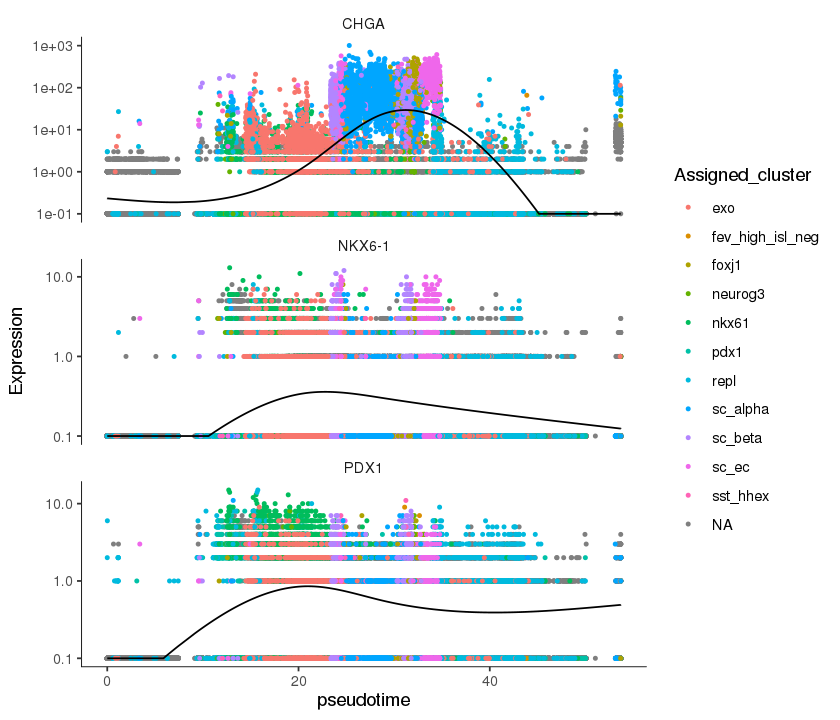

In [33]:
plot_genes_in_pseudotime(lineage_cds, 
                         color_cells_by="Assigned_cluster",
                         min_expr=0.1)

Warning message:
“Removed 62 rows containing missing values (geom_text_repel).”

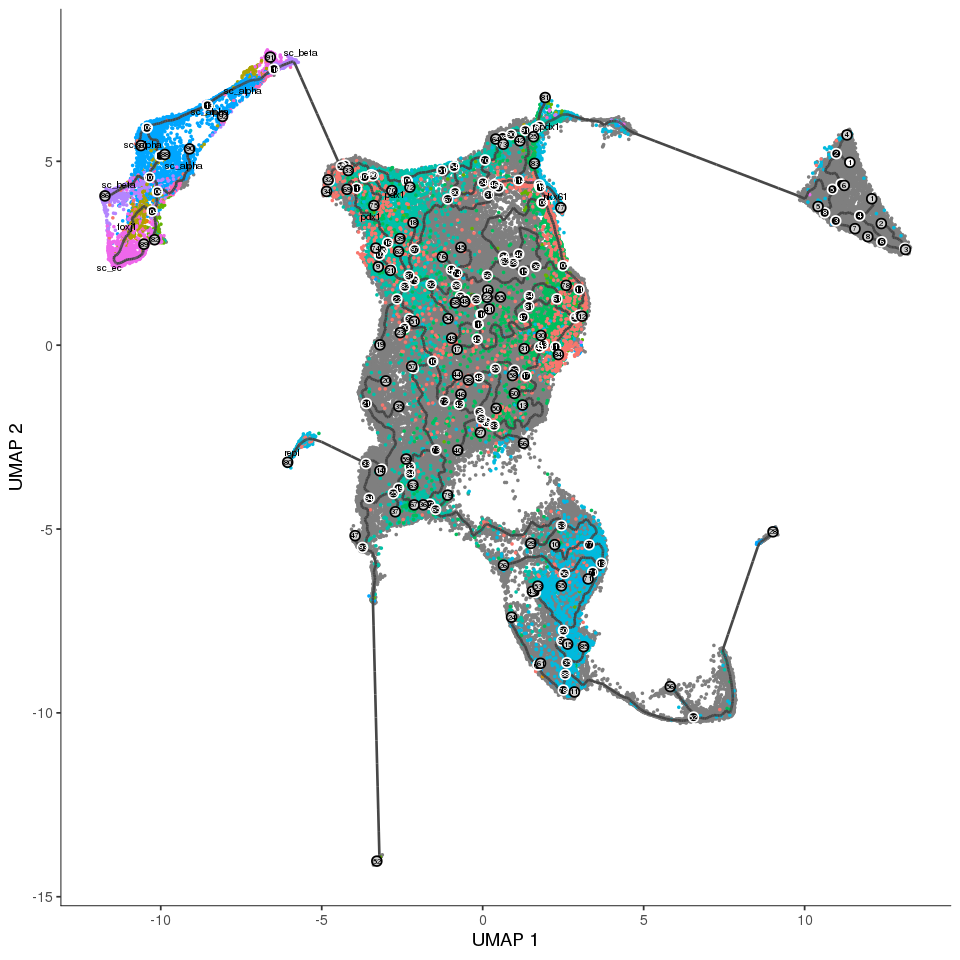

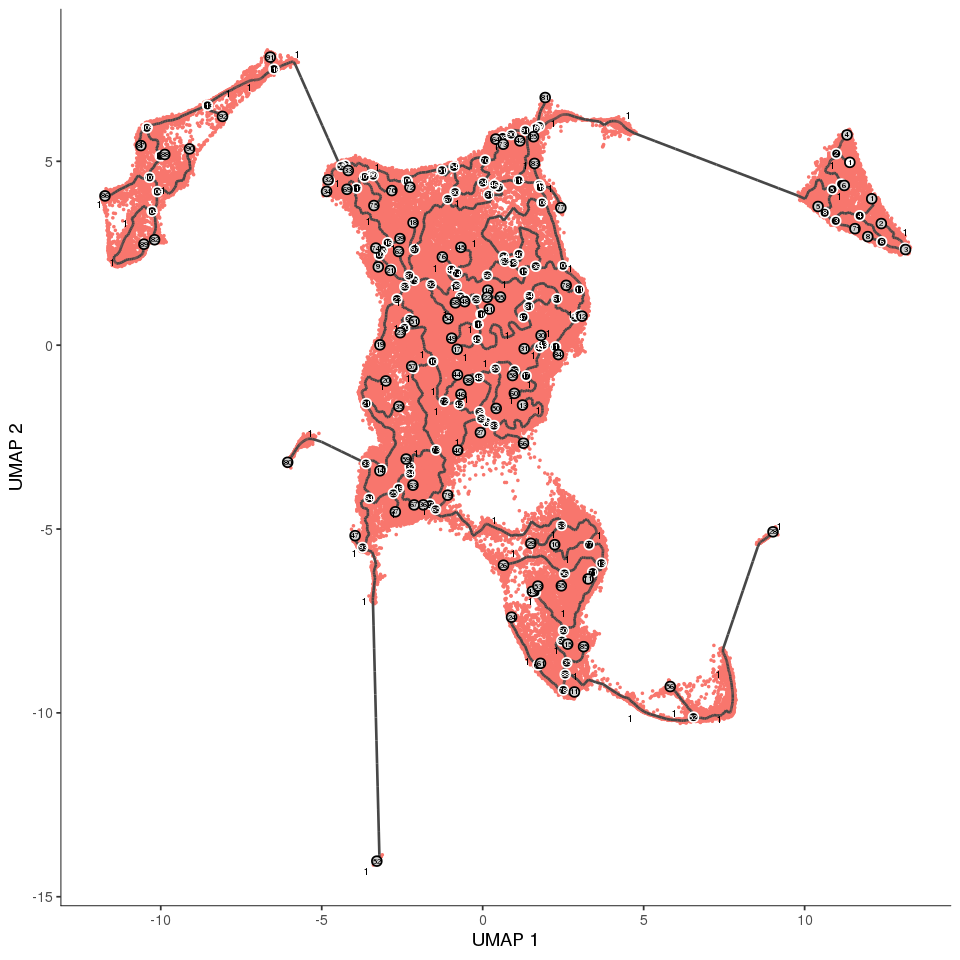

In [34]:
options(repr.plot.width =8, repr.plot.height = 8)

plot_cells(cds, 
           color_cells_by = "Assigned_cluster", 
           label_cell_groups=TRUE, 
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

plot_cells(cds, 
           color_cells_by = "partition", 
           label_cell_groups=TRUE, 
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

In [ ]:
lineage_cds